# Loading Data Using Herbie
See Herbie documentation: [Herbie](https://herbie.readthedocs.io/en/2024.3.0/user_guide/install.html)


In [ ]:
from herbie import Herbie
import matplotlib.pyplot as plt
from cartopy import feature as cfeature
import csv
import pandas as pd
import xarray
from herbie.toolbox import EasyMap, pc


In [75]:
H = Herbie(
    "2021-07-19",
    model="hrrr",
    product="sfc",
    fxx=0,
)
ds_u = H.xarray(':UGRD:10 m')
ds_v = H.xarray(':VGRD:10 m')
ds_p = H.xarray(':PRES:surface')


ds_u = ds_u.assign_coords(
    longitude=(((ds_u.longitude + 180) % 360) - 180)
)
ds_v = ds_v.assign_coords(
    longitude=(((ds_v.longitude + 180) % 360) - 180)
)

ds_p = ds_p.assign_coords(
    longitude=(((ds_p.longitude + 180) % 360) - 180)
)


# Define the bounding box
north_bound = 90  # northern latitude
south_bound = 20  # southern latitude
east_bound  = -50 # eastern longitude
west_bound  = -95# western longitude

# Subset the dataset by applying a filter on latitude and longitude using xarray's where()
subset_u = ds_u.where(
    (ds_u.latitude >= south_bound) & (ds_u.latitude <= north_bound) &
    (ds_u.longitude >= west_bound) & (ds_u.longitude <= east_bound),
    drop=True
)

subset_v = ds_v.where(
    (ds_v.latitude >= south_bound) & (ds_v.latitude <= north_bound) &
    (ds_v.longitude >= west_bound) & (ds_v.longitude <= east_bound),
    drop=True
)

subset_p = ds_p.where(
    (ds_p.latitude >= south_bound) & (ds_p.latitude <= north_bound) &
    (ds_p.longitude >= west_bound) & (ds_p.longitude <= east_bound),
    drop=True
)

ds = xarray.merge([subset_u, subset_v, subset_p])

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [76]:
H.PRODUCTS

{'sfc': '2D surface level fields; 3-km resolution',
 'prs': '3D pressure level fields; 3-km resolution',
 'nat': 'Native level fields; 3-km resolution',
 'subh': 'Subhourly grids; 3-km resolution'}

In [77]:
# Gather latitude and longitude values for each hurricane track
points = []
currHur = ''
hur = {'latitude': [], 'longitude': [], 'time': []}
with open('filtered_data.csv', 'r') as f_in:
    reader = csv.reader(f_in)
    next(reader)
    for line in reader:
        while len(line[4]) < 4: line[4] = '0' + line[4]
        if currHur != line[0]:
            currHur = line[0]
            currTime = pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M')

            points.append(pd.DataFrame(hur))
            hur = {
                'latitude': [float(line[7])],
                'longitude': [float(line[8])],
                'time': [(pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M') - currTime)/pd.Timedelta('1 hour')]
                }
        else:
            hur['latitude'].append(float(line[7]))
            hur['longitude'].append(float(line[8]))
            hur['time'].append((pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M') - currTime)/pd.Timedelta('1 hour'))

points.pop(0)
points[0]

,latitude,longitude,time
0,22.7,-72.5,0.0
1,24.1,-73.1,6.0
2,25.4,-73.5,12.0
3,26.8,-73.6,18.0
4,28.5,-73.6,24.0
5,30.5,-73.4,30.0
6,32.5,-73.2,36.0
7,34.2,-72.7,42.0
8,35.5,-71.2,48.0
9,36.8,-69.3,54.0


In [78]:
dsi = ds.herbie.pick_points(
    points[0].loc[:, 'latitude':'longitude'],
    method='nearest',
)
dsi

INFO: 🌱 Growing new BallTree...🌳 BallTree grew in 0.59 seconds.
INFO: Saved BallTree to C:\Users\joebe\data\BallTree\hrrr_841-1059.pkl


<xarray.Dataset>
Dimensions:              (point: 11)
Coordinates:
    time                 datetime64[ns] 2021-07-19
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 10.0
    latitude             (point) float64 22.7 24.1 25.39 ... 35.51 36.79 38.1
    longitude            (point) float64 -72.49 -73.1 -73.49 ... -69.32 -66.92
    valid_time           datetime64[ns] 2021-07-19
    gribfile_projection  object None
    surface              float64 0.0
    point_grid_distance  (point) float64 1.33 0.03443 0.994 ... 1.794 1.501
    point_latitude       (point) float64 22.7 24.1 25.4 26.8 ... 35.5 36.8 38.1
    point_longitude      (point) float64 -72.5 -73.1 -73.5 ... -71.2 -69.3 -66.9
Dimensions without coordinates: point
Data variables:
    u10                  (point) float32 -8.999 -8.186 -7.436 ... 2.876 2.376
    v10                  (point) float32 -1.151 -0.9636 -1.026 ... 7.786 5.849
    sp                   (point) float32 1.019e+05 1.02e+05 ... 1.02e+05
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              C:\Users\joebe\data\hrrr\20210719\subset_6eeffd3...
    search:                  :UGRD:10 m

In [79]:
matched = []
for point in points:
    matched.append(ds.herbie.pick_points(point))

matched[0]

       latitude  longitude  time  point_grid_distance  grid_index  y_grid  \
point                                                                       
8          28.5     -101.7  42.0           584.271213      132878     158   
9          29.7     -103.3  48.0           734.495504      173246     206   

       x_grid  latitude_grid  longitude_grid  
point                                         
8           0      28.521982      -95.719777  
9           0      29.800206      -95.691234  



<xarray.Dataset>
Dimensions:              (point: 11)
Coordinates:
    time                 datetime64[ns] 2021-07-19
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 10.0
    latitude             (point) float64 22.7 24.1 25.39 ... 35.51 36.79 38.1
    longitude            (point) float64 -72.49 -73.1 -73.49 ... -69.32 -66.92
    valid_time           datetime64[ns] 2021-07-19
    gribfile_projection  object None
    surface              float64 0.0
    point_grid_distance  (point) float64 1.33 0.03443 0.994 ... 1.794 1.501
    point_latitude       (point) float64 22.7 24.1 25.4 26.8 ... 35.5 36.8 38.1
    point_longitude      (point) float64 -72.5 -73.1 -73.5 ... -71.2 -69.3 -66.9
    point_time           (point) float64 0.0 6.0 12.0 18.0 ... 48.0 54.0 60.0
Dimensions without coordinates: point
Data variables:
    u10                  (point) float32 -8.999 -8.186 -7.436 ... 2.876 2.376
    v10                  (point) float32 -1.151 -0.9636 -1.026 ... 7.786 5.849
    sp                   (point) float32 1.019e+05 1.02e+05 ... 1.02e+05
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              C:\Users\joebe\data\hrrr\20210719\subset_6eeffd3...
    search:                  :UGRD:10 m

In [80]:
for i in range(len(matched)):
    matched[i] = matched[i].swap_dims({"point": "point_time"})

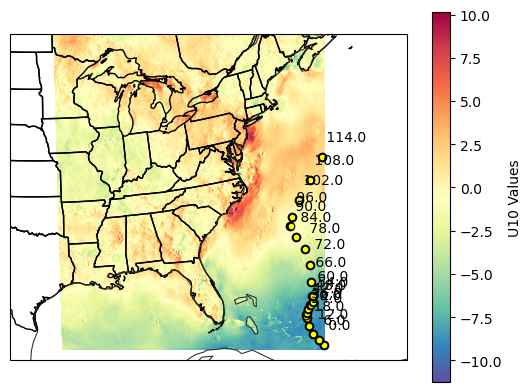

In [81]:
ax = EasyMap(crs=ds.herbie.crs).ax

c = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.u10,
    cmap="Spectral_r",
    transform=pc,
)

for i in matched[1].point_time:
    z = matched[1].sel(point_time=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_time.item()}\n",
        transform=pc,
    )

ax.set_extent([-98, -65, 25, 45], crs=pc)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.adjust_extent()


fig = plt.gcf()  
fig.colorbar(c, ax=ax, orientation='vertical', label='U10 Values')

plt.show()

